In [ ]:
import sklearn
import pandas as pd 
import numpy as np
import scipy
import itertools
import readline
import matplotlib
import matplotlib.pyplot as plt
from ipython_helpers import (
    print_full
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    fbeta_score,
    make_scorer,
    recall_score,
    precision_score,
    r2_score,
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import (
    LinearSVC,
    SVC,
    NuSVC
)
%matplotlib inline  

In [70]:
def make_input_df(df):
    X = pd.DataFrame()
    X['CASHMTA'] = df['CASHMTA_win']
    X['EXRET_AVG'] = df['EXRET_AVG_win']
    X['MB'] = df['MB_win']
    X['NIMTA_AVG'] = df['NIMTA_AVG_win']
    X['PRICE'] = df['PRICE_win']
    X['RSIZE'] = df['RSIZE_win']
    X['SIGMA'] = df['SIGMA_win']
    X['TLMTA'] = df['TLMTA_win']
    
    return X

def make_output_df(df):
    y = pd.DataFrame()
    y['is_bankrupt'] = df['is_bankrupt_within_12']
    
    return y


def make_train_and_test_df(train_df, test_df):
    X_train = make_input_df(train_df)
    X_test = make_input_df(test_df)
    y_train = make_output_df(train_df)
    y_test = make_output_df(test_df)
    
    return X_train, X_test, y_train, y_test


def make_base_rate_model(X):
    y = np.zeros(X.shape[0], dtype=bool)

    return y


def make_time_series_iterable(df, start_year):
    end_year = df['year'].max() + 1
    input_df = make_input_df(df)

    iterator = []
    for year in range(start_year, end_year):
        train_index = df[df['year'] < year].index.values.astype(int)
        test_index = df[df['year'] == year].index.values.astype(int)
        iterator.append((train_index, test_index))
        
    return iterator


def plot_roc_curve(y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return fpr, tpr, thresholds


def plot_confusion_matrix(test_output, predicted_output, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(test_output, predicted_output)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
def display_all_results(x_test, y_test, estimator, probability=False):
    y_pred_bin = estimator.predict(x_test)
    print("F1 Score")
    print(f1_score(y_test, y_pred_bin))
    
    print("Recall Score")
    print(recall_score(y_test, y_pred_bin))
    
    print("Precision Score")
    print(precision_score(y_test, y_pred_bin))

    print("Detailed classification report:")

    print(classification_report(y_test, y_pred_bin))
    print()

    print("Confusion Matrix:")
    plot_confusion_matrix(y_test, y_pred_bin, ['Active', 'Bankrupt'])
    print()

    if probability:
        print("Roc Curve:")
        y_pred_prob = estimator.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test, y_pred_prob)
        print()
        

def train_model_by_random_search_cv(X_train, X_test, y_train, y_test, estimator, tuned_parameters, custom_iterable=None, num_iter=10, scores=None, probability=False):

    if scores is None:
        scores = ['roc_auc', 'precision']
    
    for score in scores:
        print("Tuning hyper-parameters for %s" % score)
        print()

        clf = RandomizedSearchCV(estimator, tuned_parameters, cv=custom_iterable, scoring=score, verbose=1, n_iter=num_iter, n_jobs=-1)
        clf.fit(X_train, y_train.values.ravel())

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        
        display_all_results(X_test, y_test, clf, probability)

    return clf


def train_model_by_grid_search_cv(X_train, X_test, y_train, y_test, estimator, tuned_parameters, custom_iterable, scores=None, probability=False):

    if scores is None:
        scores = ['roc_auc', 'precision']
    
    for score in scores:
        print("Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(estimator, tuned_parameters, cv=custom_iterable, scoring=score, verbose=1, n_jobs=-1)
        clf.fit(X_train, y_train.values.ravel())

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        
        display_all_results(X_test, y_test, clf, probability)
        
    return clf 

            

# Read Data

In [3]:
train_df = pd.read_csv("../../../../Development/econ985/campbell_data/train_df_annual_12.csv")
test_df = pd.read_csv("../../../../Development/econ985/campbell_data/test_df_annual_12.csv")

In [4]:
X_train, X_test, y_train, y_test = make_train_and_test_df(train_df, test_df)

# Train Models

### 1) Dummy Classifier (Always Predicts False for Bankruptcy)

F1 Score
0.0
Recall Score
0.0
Precision Score
0.0
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      1.00      1.00     39255
       True       0.00      0.00      0.00        40

avg / total       1.00      1.00      1.00     39295

()
Confusion Matrix:


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[39255     0]
 [   40     0]]


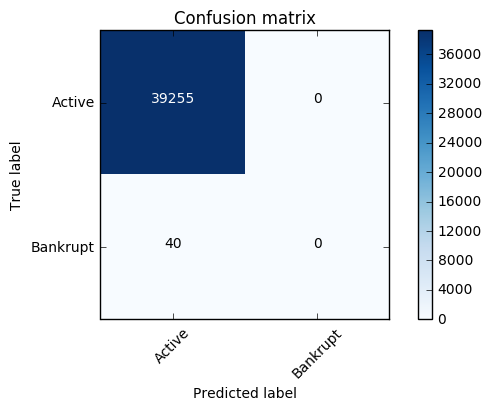

()


In [5]:
estimator_dummy = DummyClassifier(strategy='most_frequent', constant=False)
estimator_dummy.fit(X_train, y_train.values.ravel())
display_all_results(X_test, y_test, estimator_dummy)

### 2) Logistic Regression

In [33]:
estimator_lr = LogisticRegression(penalty='l2')
tuned_parameters_lr = {'C': scipy.stats.expon(scale=100), 'class_weight': ['balanced', {True: 1000}, {True: 3000}]}
ts_iterable = make_time_series_iterable(train_df, 1995)
scores_lr = ['f1']

Tuning hyper-parameters for f1
()
Fitting 11 folds for each of 10 candidates, totalling 110 fits


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done 110 out of 110

Best parameters set found on development set:
()
{'C': 58.380589498177528, 'class_weight': 'balanced'}
()
F1 Score
0.00710104596488
Recall Score
0.925
Precision Score
0.00356420383393
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.74      0.85     39255
       True       0.00      0.93      0.01        40

avg / total       1.00      0.74      0.85     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[28911 10344]
 [    3    37]]


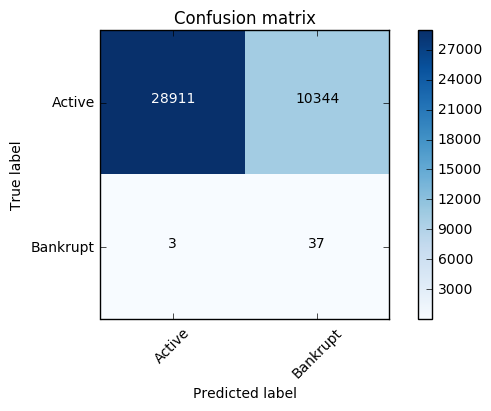

()
Roc Curve:


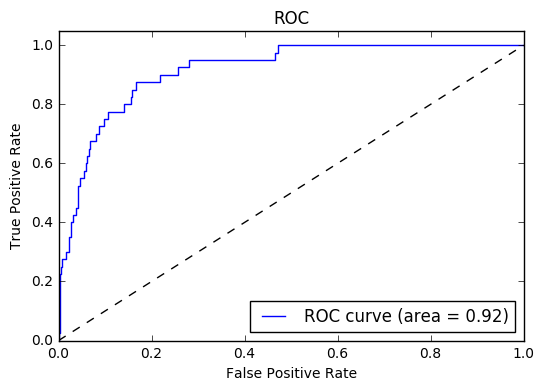

()


In [34]:
trained_estimator_lr = train_model_by_random_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_lr, 
    tuned_parameters_lr, 
    ts_iterable, 
    scores_lr,
    probability=True
)

### 3) Decision Tree

##### Decision Tree - Objective=f1

Tuning hyper-parameters for f1
()
Fitting 11 folds for each of 72 candidates, totalling 792 fits


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done 192 tasks     

Best parameters set found on development set:
()
{'min_samples_leaf': 10, 'criterion': 'gini', 'max_depth': None, 'class_weight': 'balanced'}
()
F1 Score
0.00584795321637
Recall Score
0.025
Precision Score
0.00331125827815
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.99      1.00     39255
       True       0.00      0.03      0.01        40

avg / total       1.00      0.99      0.99     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[38954   301]
 [   39     1]]


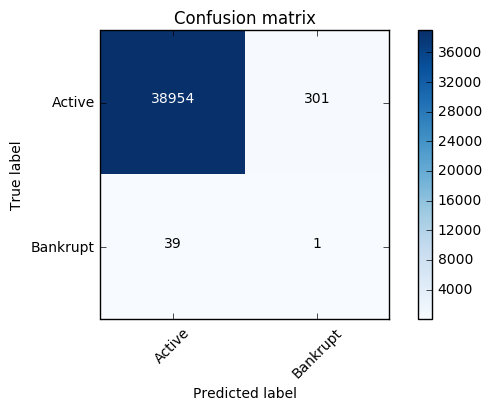

()


In [49]:
estimator_dt = DecisionTreeClassifier()
tuned_parameters = {
    'class_weight': ['balanced', {True: 1000}, {True: 2000}, {True: 3000}],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['f1']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=f2

Tuning hyper-parameters for make_scorer(fbeta_score, beta=2, pos_label=True, average=binary)
()
Fitting 11 folds for each of 72 candidates, totalling 792 fits


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.3s
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done 192 tasks     

Best parameters set found on development set:
()
{'min_samples_leaf': 10, 'criterion': 'entropy', 'max_depth': None, 'class_weight': {True: 3000}}
()
F1 Score
0.0287769784173
Recall Score
0.1
Precision Score
0.0168067226891
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.99      1.00     39255
       True       0.02      0.10      0.03        40

avg / total       1.00      0.99      1.00     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[39021   234]
 [   36     4]]


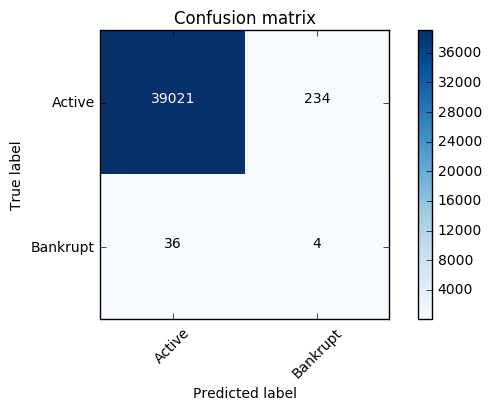

()


In [48]:
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=True, average='binary')
scores = [f2_scorer]
tuned_parameters = {
    'class_weight': ['balanced', {True: 1000}, {True: 2000}, {True: 3000}],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=recall, Class Weight = balanced (~490)

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 18 candidates, totalling 198 fits


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done 198 out of 198 | e

Best parameters set found on development set:
()
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
()
F1 Score
0.0088188976378
Recall Score
0.7
Precision Score
0.00443740095087
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.84      0.91     39255
       True       0.00      0.70      0.01        40

avg / total       1.00      0.84      0.91     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[32973  6282]
 [   12    28]]


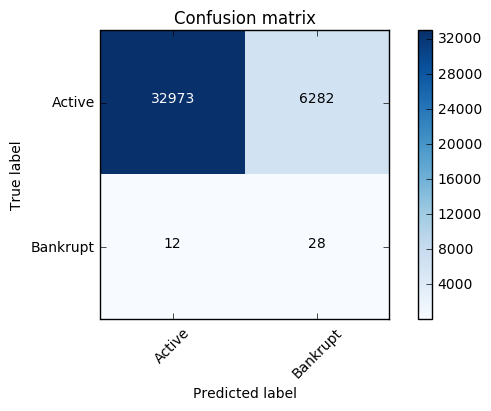

()


In [50]:
estimator_dt = DecisionTreeClassifier(class_weight='balanced')
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=recall, Class Weight = 1000

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 18 candidates, totalling 198 fits


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done 198 out of 198 | e

Best parameters set found on development set:
()
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
()
F1 Score
0.00802041560335
Recall Score
0.825
Precision Score
0.0040297960679
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.79      0.88     39255
       True       0.00      0.82      0.01        40

avg / total       1.00      0.79      0.88     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[31099  8156]
 [    7    33]]


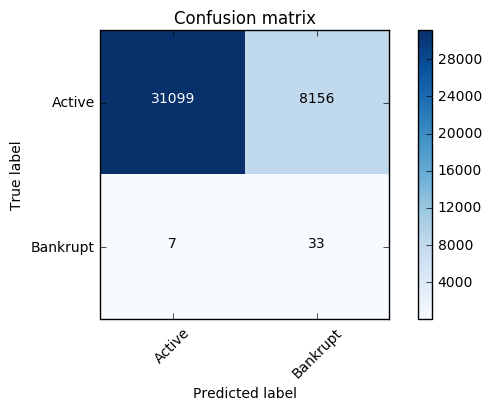

()


In [51]:
estimator_dt = DecisionTreeClassifier(class_weight={True:1000})
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=recall, Class Weight = 2000

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 18 candidates, totalling 198 fits


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  1.4min finished


Best parameters set found on development set:
()
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
()
F1 Score
0.00330445655086
Recall Score
0.925
Precision Score
0.00165518475441
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.43      0.60     39255
       True       0.00      0.93      0.00        40

avg / total       1.00      0.43      0.60     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[16938 22317]
 [    3    37]]


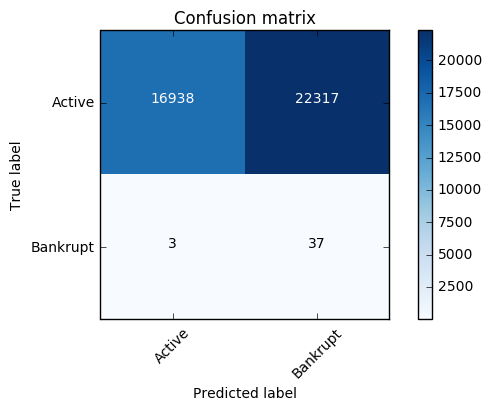

()


In [52]:
estimator_dt = DecisionTreeClassifier(class_weight={True:2000})
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=recall, Class Weight = 3000

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 18 candidates, totalling 198 fits


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done 198 out of 198 | e

Best parameters set found on development set:
()
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
()
F1 Score
0.00272946775379
Recall Score
0.975
Precision Score
0.00136664680941
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.27      0.43     39255
       True       0.00      0.97      0.00        40

avg / total       1.00      0.27      0.43     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[10757 28498]
 [    1    39]]


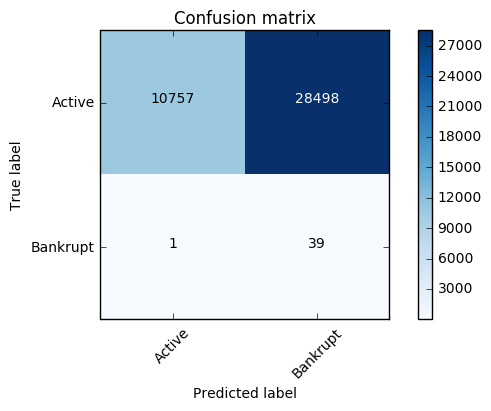

()


In [53]:
estimator_dt = DecisionTreeClassifier(class_weight={True:3000})
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

## 3) SVM

#### Linear SVM

In [62]:
estimator_svm_linear = LinearSVC(class_weight={True: 1000}, verbose=3, max_iter=5000)
estimator_svm_linear.fit(X_train, y_train.values.ravel())

[LibLinear]

LinearSVC(C=1.0, class_weight={True: 1000}, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=3)

Confusion matrix, without normalization
[[39255     0]
 [   40     0]]


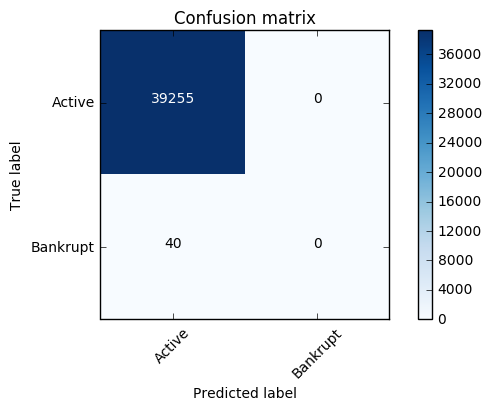

In [65]:
y_predict = estimator_svm_linear.predict(X_test)
plot_confusion_matrix(y_test, y_predict, ['Active', 'Bankrupt'])

#### SVC

[LibSVM]F1 Score
0.00738318742749
Recall Score
0.875
Precision Score
0.00370723440314
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.76      0.86     39255
       True       0.00      0.88      0.01        40

avg / total       1.00      0.76      0.86     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[29849  9406]
 [    5    35]]


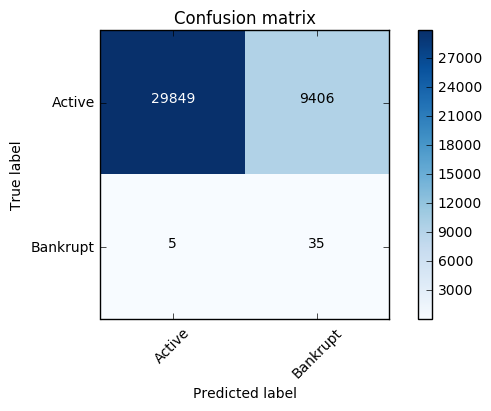

()


In [67]:
estimator_svm_svc = SVC(class_weight="balanced", verbose=1, kernel='linear')
estimator_svm_svc.fit(X_train, y_train.values.ravel())
display_all_results(X_test, y_test, estimator_svm_svc)

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 1 candidates, totalling 11 fits


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed: 52.2min finished


[LibSVM]Best parameters set found on development set:
()
{'kernel': 'linear'}
()
F1 Score
0.00738318742749
Recall Score
0.875
Precision Score
0.00370723440314
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.76      0.86     39255
       True       0.00      0.88      0.01        40

avg / total       1.00      0.76      0.86     39295

()
Confusion Matrix:
Confusion matrix, without normalization
[[29849  9406]
 [    5    35]]


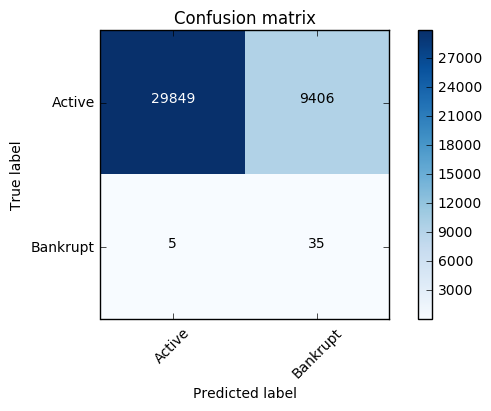

()


In [66]:
estimator_svm_svc = svm.SVC(class_weight="balanced", verbose=1)
tuned_parameters_svm_svc = {
    'kernel': ['linear'],
}
scores_svm_svc = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_svm_svc, 
    tuned_parameters_svm_svc,
    scores_svm_svc
)

In [ ]:
estimator_svm_svc = svm.SVC(kernel='linear', probability=True, verbose=1)
tuned_parameters_svm_svc = 
    'C': scipy.stats.expon(scale=100),
    'class_weight': ["balanced", {True: 1000}, {True: 2000}, {True: 3000}],  
}
scores_svm_svc = ['recall']
trained_estimator_df = train_model_by_random_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_svm_svc, 
    tuned_parameters_svm_svc,
    num_iter=20,
    scores=scores_svm_svc,
    probability=True
)

#### NuSVC

In [ ]:
2 + 2

## 4) Random Forest

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 108 candidates, totalling 1188 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

Best parameters set found on development set:
()
{'n_estimators': 10, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
()
F1 Score
0.0154727793696
Recall Score
0.675
Precision Score
0.00782608695652
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.91      0.95     39252
       True       0.01      0.68      0.02        40

avg / total       1.00      0.91      0.95     39292

()
Confusion Matrix:
Confusion matrix, without normalization
[[35829  3423]
 [   13    27]]


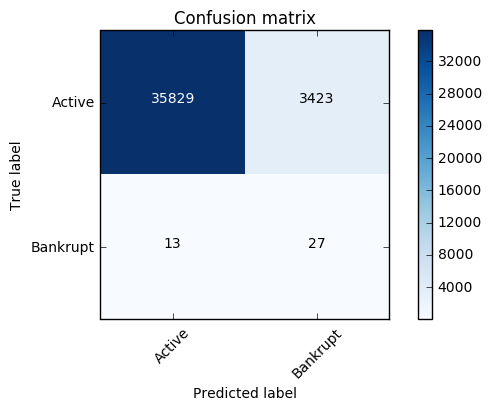

()
Tuning hyper-parameters for roc_auc
()
Fitting 11 folds for each of 108 candidates, totalling 1188 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x1020dc230, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/wenta...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x1020dc230, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/wenta...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/usr/local/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'estimator_rf = RandomForestClassifier(class_we...rameters_rf,\n    ts_iterable,\n    scores_rf\n)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-02-22T02:08:40.079678', u'msg_id': u'A656D66B96164E329A2DDF62E7D478FC', u'msg_type': u'execute_request', u'session': u'3428956673214AE189669EF0F7DA8F02', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'A656D66B96164E329A2DDF62E7D478FC', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['3428956673214AE189669EF0F7DA8F02']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'estimator_rf = RandomForestClassifier(class_we...rameters_rf,\n    ts_iterable,\n    scores_rf\n)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-02-22T02:08:40.079678', u'msg_id': u'A656D66B96164E329A2DDF62E7D478FC', u'msg_type': u'execute_request', u'session': u'3428956673214AE189669EF0F7DA8F02', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'A656D66B96164E329A2DDF62E7D478FC', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['3428956673214AE189669EF0F7DA8F02'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'estimator_rf = RandomForestClassifier(class_we...rameters_rf,\n    ts_iterable,\n    scores_rf\n)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-02-22T02:08:40.079678', u'msg_id': u'A656D66B96164E329A2DDF62E7D478FC', u'msg_type': u'execute_request', u'session': u'3428956673214AE189669EF0F7DA8F02', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'A656D66B96164E329A2DDF62E7D478FC', 'msg_type': u'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'estimator_rf = RandomForestClassifier(class_we...rameters_rf,\n    ts_iterable,\n    scores_rf\n)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'estimator_rf = RandomForestClassifier(class_we...rameters_rf,\n    ts_iterable,\n    scores_rf\n)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'estimator_rf = RandomForestClassifier(class_we...rameters_rf,\n    ts_iterable,\n    scores_rf\n)',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'estimator_rf = RandomForestClassifier(class_we...rameters_rf,\n    ts_iterable,\n    scores_rf\n)',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'estimator_rf = RandomForestClassifier(class_we...rameters_rf,\n    ts_iterable,\n    scores_rf\n)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-48-84f4873a70ae>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 1125a5a50, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x10e4532b0, file "<ipython-input-48-84f4873a70ae>", line 10>
        result = <ExecutionResult object at 1125a5a50, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x10e4532b0, file "<ipython-input-48-84f4873a70ae>", line 10>, result=<ExecutionResult object at 1125a5a50, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x10e4532b0, file "<ipython-input-48-84f4873a70ae>", line 10>
        self.user_global_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'DummyClassifier': <class 'sklearn.dummy.DummyClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u'import sklearn\nimport pandas as pd \nimport n...ers import (\n    print_full\n)\nimport readline', u"def make_input_df(df):\n    X = pd.DataFrame()...ies_split_by_year(start_year):\n    return\n    ", u'train_df = pd.read_csv("../Data/campbell_data/...read_csv("../Data/campbell_data/test_df_12.csv")', u'train_df', u'train_df', u'X_train, X_test, y_train, y_test = make_train_and_test_df(train_df, test_df)', u"def make_input_df(df):\n    X = pd.DataFrame()...ies_split_by_year(start_year):\n    return\n    ", u'X_train, X_test, y_train, y_test = make_train_and_test_df(train_df, test_df)', u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u"import sklearn\nimport pandas as pd \nimport n...ier\n\nget_ipython().magic(u'matplotlib inline')", u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u'def make_input_df(df):\n    X = pd.DataFrame()...est, y_pred_prob)\n        print()\n            ', u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u'def make_input_df(df):\n    X = pd.DataFrame()...est, y_pred_prob)\n        print()\n            ', u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u'def make_input_df(df):\n    X = pd.DataFrame()...est, y_pred_prob)\n        print()\n            ', u'def make_input_df(df):\n    X = pd.DataFrame()...est, y_pred_prob)\n        print()\n            ', u"estimator_lr = LogisticRegression(penalty='l2'...ies_iterable(train_df, 1995)\nscores_lr = ['f1']", ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {4:         Unnamed: 0  PERMNO    datadate lagged_da...0.0             3.0  

[128493 rows x 20 columns], 5:         Unnamed: 0  PERMNO    datadate lagged_da...0.0             3.0  

[128493 rows x 20 columns], 29:       is_bankrupt
0           False
1           ...False
39291       False

[39292 rows x 1 columns], 31:       is_bankrupt
0           False
1           ...False
39291       False

[39292 rows x 1 columns], 32:       is_bankrupt
0           False
26180       ... True
30857        True

[39292 rows x 1 columns], 45: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False), 46: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False)}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'X_test':         CASHMTA  EXRET_AVG        MB  NIMTA_AVG ...1  0.098237  0.185873  

[39292 rows x 8 columns], 'X_train':          CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns], ...}
        self.user_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'DummyClassifier': <class 'sklearn.dummy.DummyClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u'import sklearn\nimport pandas as pd \nimport n...ers import (\n    print_full\n)\nimport readline', u"def make_input_df(df):\n    X = pd.DataFrame()...ies_split_by_year(start_year):\n    return\n    ", u'train_df = pd.read_csv("../Data/campbell_data/...read_csv("../Data/campbell_data/test_df_12.csv")', u'train_df', u'train_df', u'X_train, X_test, y_train, y_test = make_train_and_test_df(train_df, test_df)', u"def make_input_df(df):\n    X = pd.DataFrame()...ies_split_by_year(start_year):\n    return\n    ", u'X_train, X_test, y_train, y_test = make_train_and_test_df(train_df, test_df)', u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u"import sklearn\nimport pandas as pd \nimport n...ier\n\nget_ipython().magic(u'matplotlib inline')", u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u'def make_input_df(df):\n    X = pd.DataFrame()...est, y_pred_prob)\n        print()\n            ', u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u'def make_input_df(df):\n    X = pd.DataFrame()...est, y_pred_prob)\n        print()\n            ', u"estimator_dummy = DummyClassifier(strategy='mo...lay_all_results(X_test, y_test, estimator_dummy)", u'def make_input_df(df):\n    X = pd.DataFrame()...est, y_pred_prob)\n        print()\n            ', u'def make_input_df(df):\n    X = pd.DataFrame()...est, y_pred_prob)\n        print()\n            ', u"estimator_lr = LogisticRegression(penalty='l2'...ies_iterable(train_df, 1995)\nscores_lr = ['f1']", ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {4:         Unnamed: 0  PERMNO    datadate lagged_da...0.0             3.0  

[128493 rows x 20 columns], 5:         Unnamed: 0  PERMNO    datadate lagged_da...0.0             3.0  

[128493 rows x 20 columns], 29:       is_bankrupt
0           False
1           ...False
39291       False

[39292 rows x 1 columns], 31:       is_bankrupt
0           False
1           ...False
39291       False

[39292 rows x 1 columns], 32:       is_bankrupt
0           False
26180       ... True
30857        True

[39292 rows x 1 columns], 45: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False), 46: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False)}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'X_test':         CASHMTA  EXRET_AVG        MB  NIMTA_AVG ...1  0.098237  0.185873  

[39292 rows x 8 columns], 'X_train':          CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns], ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/wentaoxu/Dropbox/Classes/Econ_985/code/<ipython-input-48-84f4873a70ae> in <module>()
     13     y_train, 
     14     y_test, 
     15     estimator_rf, 
     16     tuned_parameters_rf,
     17     ts_iterable,
---> 18     scores_rf
     19 )
     20 
     21 
     22 

...........................................................................
/Users/wentaoxu/Dropbox/Classes/Econ_985/code/<ipython-input-44-93079423d785> in train_model_by_grid_search_cv(X_train=         CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns], X_test=        CASHMTA  EXRET_AVG        MB  NIMTA_AVG ...1  0.098237  0.185873  

[39292 rows x 8 columns], y_train=       is_bankrupt
0            False
1         ...lse
128492       False

[128493 rows x 1 columns], y_test=      is_bankrupt
0           False
1           ...False
39291       False

[39292 rows x 1 columns], estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False), tuned_parameters={'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 5, 10], 'n_estimators': [10, 100, 1000]}, custom_iterable=[(array([     0,      1,      2, ..., 128484, 128485, 128486]), array([    11,     58,     77, ..., 128414, 128461, 128487])), (array([     0,      1,      2, ..., 128485, 128486, 128487]), array([    12,     59,     78, ..., 128415, 128462, 128488])), (array([     0,      1,      2, ..., 128486, 128487, 128488]), array([    13,     60,     79, ..., 128416, 128463, 128489])), (array([     0,      1,      2, ..., 128487, 128488, 128489]), array([    14,     61,     80, ..., 128417, 128464, 128490])), (array([     0,      1,      2, ..., 128488, 128489, 128490]), array([    15,     81,    108, ..., 128369, 128404, 128491])), (array([     0,      1,      2, ..., 128489, 128490, 128491]), array([    16,     82,    109, ..., 128343, 128370, 128492])), (array([     0,      1,      2, ..., 128490, 128491, 128492]), array([    17,     83,    110, ..., 128253, 128344, 128371])), (array([     0,      1,      2, ..., 128490, 128491, 128492]), array([    18,    111,    143, ..., 128254, 128345, 128372])), (array([     0,      1,      2, ..., 128490, 128491, 128492]), array([    19,    144,    164, ..., 128255, 128346, 128373])), (array([     0,      1,      2, ..., 128490, 128491, 128492]), array([    20,    145,    165, ..., 128256, 128347, 128374])), (array([     0,      1,      2, ..., 128490, 128491, 128492]), array([    21,    146,    166, ..., 128257, 128348, 128375]))], scores=['recall', 'roc_auc'], probability=False)
    156     for score in scores:
    157         print("Tuning hyper-parameters for %s" % score)
    158         print()
    159 
    160         clf = GridSearchCV(estimator, tuned_parameters, cv=custom_iterable, scoring=score, verbose=1, n_jobs=-1)
--> 161         clf.fit(X_train, y_train.values.ravel())
    162 
    163         print("Best parameters set found on development set:")
    164         print()
    165         print(clf.best_params_)

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=[(array([     0,      1, ..., 12..._score=True,
       scoring='roc_auc', verbose=1), X=         CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns], y=array([False, False, False, ..., False, False, False], dtype=bool), groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method GridSearchCV._fit of GridSearchCV(...score=True,
       scoring='roc_auc', verbose=1)>
        X =          CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns]
        y = array([False, False, False, ..., False, False, False], dtype=bool)
        groups = None
        self.param_grid = {'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 5, 10], 'n_estimators': [10, 100, 1000]}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=[(array([     0,      1, ..., 12..._score=True,
       scoring='roc_auc', verbose=1), X=         CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns], y=array([False, False, False, ..., False, False, False], dtype=bool), groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Feb 22 14:08:46 2017
PID: 15814               Python 2.7.12: /Users/wentaoxu/anaconda/bin/python
...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False),          CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns], array([False, False, False, ..., False, False, False], dtype=bool), make_scorer(roc_auc_score, needs_threshold=True), array([     0,      1,      2, ..., 128488, 128489, 128490]), array([    15,     81,    108, ..., 128369, 128404, 128491]), 1, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 10})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False),          CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns], array([False, False, False, ..., False, False, False], dtype=bool), make_scorer(roc_auc_score, needs_threshold=True), array([     0,      1,      2, ..., 128488, 128489, 128490]), array([    15,     81,    108, ..., 128369, 128404, 128491]), 1, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 10}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False), X=         CASHMTA  EXRET_AVG        MB  NIMTA_AVG...  0.204925  0.230076  

[128493 rows x 8 columns], y=array([False, False, False, ..., False, False, False], dtype=bool), scorer=make_scorer(roc_auc_score, needs_threshold=True), train=array([     0,      1,      2, ..., 128488, 128489, 128490]), test=array([    15,     81,    108, ..., 128369, 128404, 128491]), verbose=1, parameters={'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 10}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False)
        X_test =          CASHMTA  EXRET_AVG        MB  NIMTA_AVG...91  0.120876  0.475315  

[5894 rows x 8 columns]
        y_test = array([False, False, False, ..., False, False, False], dtype=bool)
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False), X_test=         CASHMTA  EXRET_AVG        MB  NIMTA_AVG...91  0.120876  0.475315  

[5894 rows x 8 columns], y_test=array([False, False, False, ..., False, False, False], dtype=bool), scorer=make_scorer(roc_auc_score, needs_threshold=True))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False)
        X_test =          CASHMTA  EXRET_AVG        MB  NIMTA_AVG...91  0.120876  0.475315  

[5894 rows x 8 columns]
        y_test = array([False, False, False, ..., False, False, False], dtype=bool)
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=1,
            warm_start=False), X=         CASHMTA  EXRET_AVG        MB  NIMTA_AVG...91  0.120876  0.475315  

[5894 rows x 8 columns], y=array([False, False, False, ..., False, False, False], dtype=bool), sample_weight=None)
    191         if sample_weight is not None:
    192             return self._sign * self._score_func(y, y_pred,
    193                                                  sample_weight=sample_weight,
    194                                                  **self._kwargs)
    195         else:
--> 196             return self._sign * self._score_func(y, y_pred, **self._kwargs)
        self._sign = 1
        self._score_func = <function roc_auc_score>
        y = array([False, False, False, ..., False, False, False], dtype=bool)
        y_pred = array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
        self._kwargs = {}
    197 
    198     def _factory_args(self):
    199         return ", needs_threshold=True"
    200 

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/ranking.py in roc_auc_score(y_true=array([False, False, False, ..., False, False, False], dtype=bool), y_score=array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), average='macro', sample_weight=None)
    255                                         sample_weight=sample_weight)
    256         return auc(fpr, tpr, reorder=True)
    257 
    258     return _average_binary_score(
    259         _binary_roc_auc_score, y_true, y_score, average,
--> 260         sample_weight=sample_weight)
        sample_weight = None
    261 
    262 
    263 def _binary_clf_curve(y_true, y_score, pos_label=None, sample_weight=None):
    264     """Calculate true and false positives per binary classification threshold.

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/base.py in _average_binary_score(binary_metric=<function _binary_roc_auc_score>, y_true=array([False, False, False, ..., False, False, False], dtype=bool), y_score=array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), average='macro', sample_weight=None)
     79     y_type = type_of_target(y_true)
     80     if y_type not in ("binary", "multilabel-indicator"):
     81         raise ValueError("{0} format is not supported".format(y_type))
     82 
     83     if y_type == "binary":
---> 84         return binary_metric(y_true, y_score, sample_weight=sample_weight)
        binary_metric = <function _binary_roc_auc_score>
        y_true = array([False, False, False, ..., False, False, False], dtype=bool)
        y_score = array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
        sample_weight = None
     85 
     86     check_consistent_length(y_true, y_score, sample_weight)
     87     y_true = check_array(y_true)
     88     y_score = check_array(y_score)

...........................................................................
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/ranking.py in _binary_roc_auc_score(y_true=array([False, False, False, ..., False, False, False], dtype=bool), y_score=array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), sample_weight=None)
    246     0.75
    247 
    248     """
    249     def _binary_roc_auc_score(y_true, y_score, sample_weight=None):
    250         if len(np.unique(y_true)) != 2:
--> 251             raise ValueError("Only one class present in y_true. ROC AUC score "
    252                              "is not defined in that case.")
    253 
    254         fpr, tpr, tresholds = roc_curve(y_true, y_score,
    255                                         sample_weight=sample_weight)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.
___________________________________________________________________________

In [48]:
estimator_rf = RandomForestClassifier(class_weight="balanced", verbose=1)
tuned_parameters_rf = {
    'n_estimators': [10, 100, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False],
}
scores_rf = ['recall', 'roc_auc']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_rf, 
    tuned_parameters_rf,
    ts_iterable,
    scores_rf
)